# ベースモデル（LSTM）
## 特徴量：client, close, price_am, price_pm

## 注意点
・使用しているデータは2011年4月1日以降のデータです\
・使った特徴量は上記の4つのみです\
・前処理は何もしていません\
・Trainデータの中から、時系列的に最後の1割を検証用データとして切り離しています

検証データについては以下のQ＆Aが参考になります。\
https://datascience.stackexchange.com/questions/109066/validation-split-in-time-series-data-for-lstm-model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
sns.set()

from datetime import date
import holidays
import datetime as dt
import japanize_matplotlib

In [2]:
data = pd.read_csv("./train.csv")
data.head()

,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17,0,0,-1,-1
1,2010-07-02,18,0,0,-1,-1
2,2010-07-03,20,0,0,-1,-1
3,2010-07-04,20,0,0,-1,-1
4,2010-07-05,14,0,0,-1,-1


In [3]:
# 0	datetime	日時（YYYY-MM-DD）	文字列
# 1	y	引越し数	数値：整数
# 2	client	法人が絡む特殊な引越し日フラグ	数値：整数（0,1）
# 3	close	休業日	数値：整数（0,1）
# 4	price_am	午前の料金区分（-1は欠損を表す。5が最も料金が高い）	数値：整数（-1,0,1,2,3,4,5）
# 5	price_pm	午後の料金区分（-1は欠損を表す。5が最も料金が高い）	数値：整数（-1,0,1,2,3,4,5）

##　内井入力

In [4]:
from datetime import date
import holidays
holidays_d = []
for i in np.arange(0,len(data)):
    a= data["datetime"][i] in holidays.JP()
    holidays_d.append(a)
data["holidays"] = holidays_d
data = data.replace({False:0, True:1})

##　以下　寺澤さん入力

In [5]:
#datetimeを日付型に変換
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')

In [6]:
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['Weekday'] = data['datetime'].dt.strftime('%A')

## モデル実装

In [7]:
!pip3 install keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import pandas as pd

### 学習データの作成

In [8]:
# 2011年４月１日以降のデータを対象にしてベースモデルを作成する
data = data[data["datetime"] >= "2011-04-01" ]

In [9]:
#データセットを作る関数
look_back = 30


def make_dataset(raw_data, look_back=30):
    _x = []
    _y = []

    for i in range(len(raw_data) - look_back):
        _x.append(raw_data[i : i + look_back])
        _y.append(raw_data[i + look_back])
    _x = np.array(_x).reshape(len(_x), look_back, 1)
    _y = np.array(_y).reshape(len(_y), 1)

    return _x, _y

In [10]:
X_y, y_y = make_dataset(data['y'].values, look_back=look_back)
X_client, y_client = make_dataset(data['client'].values, look_back=look_back)
X_close, y_close = make_dataset(data['close'].values, look_back=look_back)
X_price_am, y_price_am = make_dataset(data['price_am'].values, look_back=look_back)
X_price_pm, y_price_pm = make_dataset(data['price_pm'].values, look_back=look_back)
X_holidays, y_holidays = make_dataset(data['holidays'].values, look_back=look_back)
X_Weekday, y_Weekday = make_dataset(data['Weekday'].values, look_back=look_back)

#入力データをまとめる
X_con = np.concatenate([X_client, X_close, X_price_am, X_price_pm], axis=2)

In [11]:
X = X_con
y = y_y

sample_size = len(data) - look_back
past_size = int(sample_size * 0.9) #サンプルデータのうち、9割を学習データ、1割を検証用データとする
future_size = sample_size - past_size + 1

#データを訓練用と検証用に分割
X_past = X[:past_size]
X_future = X[past_size-1:]
y_past = y[:past_size]
y_future = y[past_size-1:]

#訓練用データを定義
X_train = X_past
y_train = y_past

In [12]:
X_train.shape

(1617, 30, 4)

## モデル構築

In [13]:
#　モデル構築

# 1つの学習データのStep数（今回は30）

lengh_of_sequence = X_train.shape[1] 
out_nerons = 1
n_hidden = 50 #隠れ層のユニット数（数が多いほど学習モデルの複雑さが増加）
loss = tf.keras.losses.MeanAbsoluteError() # 最小絶対値誤差

model = Sequential()
model.add(LSTM(n_hidden,
               batch_input_shape=(None,lengh_of_sequence , 4) ,  #入力データの次元数
               return_sequences=False)) # バッチ型で学習するならここはFalse

model.add(Dense(out_nerons)) # 30のデータから１つの値を予測したいので１となる
model.add(Activation("linear")) # 活性化関数を指示

# compileで誤差関数：最小二乗誤差、最適化手法：Adamを用いるように定義
optimizer = Adam(lr=0.005)
model.compile(loss=loss , optimizer=optimizer)

c:\Users\ayumi\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
model.fit(X_train, y_train,
          batch_size=100,
          epochs=200, #繰り返し回数, エポック数を増やせばlossが減るのは当たり前ですが、一旦200にします。
          validation_data=[X_future, y_future] #検証用のデータを明示的に指定できる
          )

Epoch 1/200
17/17 [==============================] - 4s 79ms/step - loss: 31.1325 - val_loss: 39.3926
Epoch 2/200
17/17 [==============================] - 1s 40ms/step - loss: 23.5597 - val_loss: 34.1709
Epoch 3/200
17/17 [==============================] - 1s 33ms/step - loss: 19.6024 - val_loss: 30.1227
Epoch 4/200
17/17 [==============================] - 1s 30ms/step - loss: 16.7645 - val_loss: 26.7523
Epoch 5/200
17/17 [==============================] - 1s 34ms/step - loss: 14.9251 - val_loss: 24.1253
Epoch 6/200
17/17 [==============================] - 1s 38ms/step - loss: 13.7520 - val_loss: 22.2775
Epoch 7/200
17/17 [==============================] - 1s 44ms/step - loss: 13.1371 - val_loss: 21.0180
Epoch 8/200
17/17 [==============================] - 1s 44ms/step - loss: 12.8535 - val_loss: 20.2004
Epoch 9/200
17/17 [==============================] - 1s 42ms/step - loss: 12.7273 - val_loss: 19.7482
Epoch 10/200
17/17 [==============================] - 1s 39ms/step - loss: 12.6913

In [15]:
# 予測
predictions = model.predict(X_past)
future_predictions = model.predict(X_future)


6/6 [==============================] - 0s 9ms/step


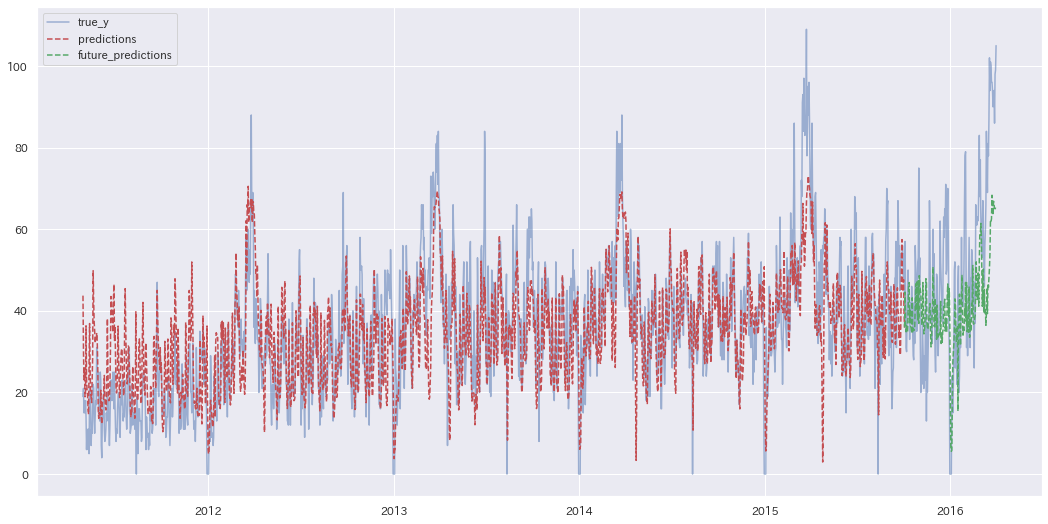

In [16]:
#可視化
plt.figure(figsize=(18,9))
plt.plot(data['datetime'][look_back:], y, color='b', label='true_y', alpha = 0.5)
plt.plot(data['datetime'][look_back:look_back + past_size], predictions, color='r', linestyle='dashed', label='predictions')
plt.plot(data['datetime'][-future_size:], future_predictions, color='g', linestyle='dashed', label='future_predictions')
plt.legend()
plt.show()

赤色が訓練データに対する予測のプロット、\
緑色が検証データに対する予測のプロットです。\


In [17]:
from sklearn.metrics import mean_absolute_error

print('訓練データに対するMAE:', mean_absolute_error(y_past, predictions))
print('検証データに対するMAE:', mean_absolute_error(y_future, future_predictions))


訓練データに対するMAE: 7.996586610302191
検証データに対するMAE: 13.831815047817335
